## Using SAS DLPy to Create Training Data Sets for Image Segmentation Models


Image segmentation describes the computer vision task of finding complete outlined shapes of one or more objects in an image. When image segmentation is performed, it determines the exact pixel mask of objects in a given image.

This example uses SAS DLPy to prepare a toy training data set for use with an image segmentation model. The learning objective is to understand the composition and role of raw input image files and mask ground truth image files, and how to use SAS DLPy to manipulate and join the contents to create your own image segmentation model training data set. In addition, it is also a good idea to learn how to examine and visually inspect an image segmentation data set for potential issues.

### Table of Contents 
- [Important Note: Client and Server Definitions](#ClientServer)
- [Prepare Resources and Configure Environment for Modeling](#getReady)
    - [Download the Example Notebook Data](#downloadData) 
    - [Extract the Raw Image Data](#installRaw)
    - [Extract the Mask Image Data](#installMask)
    - [Import Required Python and SAS DLPy Modules](#importPythonDLPy)
- [Connect to a SAS CAS Server](#launchCAS)
- [Load and Display the Raw Input Images](#loadRaw)
- [Load the Mask Input Images](#loadMask)
- [Join the Raw and Mask CAS Tables](#joinTables)
- [Use SAS DLPy to Quickly Generate Image Segmentation Training Data](#createSegmentationTbl)
- [Summary](#summary)

<a id="ClientServer"></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you might need to copy or transfer files between client and server during this example.

This step establishes server-side paths for model files, the raw model input image data, and the mask (segmentation ground truth)  image data. The images in the raw and mask image data sets are 256 x 256 in size.

In [1]:
# This code defines variables that contain server-side 
# path specifications to the raw and mask (ground truth) images 
# for an image segmentation model. 

# Server-side path to model files
model_path = r'/your-system/path-to/segmentation-files

# Server path to raw input images in .png format
raw_images = r'/your-system/path-to/segmentation-files/raw'

# Server path to mask (ground truth) images in .png format
mask_images = r'/your-system/path-to/segmentation-files/mask'  


<a id="getReady"></a>

### Prepare Resources and Configure Computing Environment for Modeling

This section organizes all of the resources that you will need and configures your computing environment for the notebook example. Performing these tasks in advance means you can run the example without multiple stops to locate and download necessary resources. This approach enables you to focus on how to use SAS DLPy to complete the analytic modeling task in this notebook.

<a id="downloadData"></a>

#### Download the Example Notebook Data

This notebook uses SAS-generated toy raw and mask image data sets with the SAS DLPy API to prepare image segmentation data for modeling. Both the raw input data set and the mask data set in this example notebook contain eight 256 x 256 images. 

Download the archived SAS model data [Image_segmentation_data_prep.zip](https://support.sas.com/documentation/prod-p/vdmml/zip/Image_segmentation_data_prep.zip) from the [SAS Viya Deep Learning Models and Tools](https://support.sas.com/documentation/prod-p/vdmml/zip/index.html) support Web page. This downloadable zip file contains separate archives for both `raw` input image and `mask` (ground truth) data sets. 

<a id="installRaw"></a>

#### Extract the Raw Image Data

From the `Image_Segmentation_Data.zip` archive, extract the raw input images in the compressed folder `raw`. Expand the collection of .png files in the `/raw` folder to the server location that you specified previously for the server path variable `raw_images`.

<a id="installMask"></a>

#### Extract the Mask Image Data

From the `Image_Segmentation_Data.zip` archive, extract the mask (ground truth) input images in the compressed folder `mask`. Expand the collection of .png files in the `/mask` folder to the server location that you specified previously for the server path variable `mask_images`.


<a id="importPythonDLPy"></a>

#### Import Required Python and SAS DLPy Modules

SAS DLPy requires a running SAS CAS server and Scripting Wrapper for Analytic Transfer (SWAT). The SWAT package is a Python interface to CAS. For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

Import SWAT and the required Python functions for the SAS DLPy API, as well as helper matplotlib libraries:

In [2]:
# Import SAS SWAT
from swat import *

# Import SAS DLPy Python libraries
import dlpy
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

# Import Matplotlib Utilities  
from matplotlib import pylab as plt
from matplotlib import image as mpimg
# display plot results in notebook cells
%matplotlib inline

<a id="launchCAS"></a>

### Connect to a SAS CAS Server 

After configuring your environment and loading the required libraries and functions, connect to your SAS CAS server and specify your CAS portID. SAS examples use port 5570 by default, but you can substitute a port number of your own choosing.

In [3]:
# Connect to the SAS CAS Server

s = CAS('your-host-name.unx.company-name.com', 5570)

In [4]:
# Load the CAS deepLearn and image action sets
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.0129s, user: 0.00956s, sys: 0.0189s, mem: 0.657mb

<a id="loadRaw"></a>

### Load and Display the Raw Input Images in SAS CAS

Create an image table named `raw` in SAS CAS and load it with the data housed in the server path `raw_images`. Next, use the `show()` function to display contents of the input data set `raw`.

In [5]:
# Create CAS table raw and load it with raw input images
raw = ImageTable.load_files(conn=s, 
                            path=raw_images
                           )

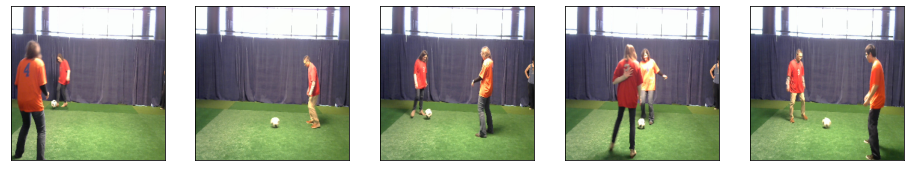

In [6]:
# Display images from the CAS table raw:
raw.show()

Use `image_summary` to display summarized image metadata parameters for the CAS table `raw`:

In [7]:
raw.image_summary

jpg                     8
minWidth              256
maxWidth              256
minHeight             256
maxHeight             256
meanWidth             256
meanHeight            256
mean1stChannel      118.9
min1stChannel           0
max1stChannel         255
mean2ndChannel    135.073
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    131.363
min3rdChannel           0
max3rdChannel         255
dtype: object

The summary shows that there are 8 .jpg images in the data set, all uniformly sized 256 x 256. BGR channel means and extremes are also provided.

<a id="loadMask"></a>

### Load the Mask Input Images into SAS CAS

Create a table named `mask` in SAS CAS and load it with the data housed in the server path `mask_images`. In this task,  mask images are not 256 x 256 matrices of pixel _BGR_ values. Instead, mask images are 256 x 256 matrices of pixel _class_ values. The model ground truth data recognizes only three classes, represented by integers [0, 1, 2]. 

- Class 0 pixels are `background` pixels. Any pixel that is not part of a `player` or `ball` object is a `background` pixel.
- Class 1 pixels are part of a `player` object. 
- Class 2 pixels are part of a `ball` object. 

Since the matrix cells that comprise the mask image spaces contain only class type integers [0,1,2] (and not BGR pixel values), BGR-based image view utilities render only black space results. The ground truth mask images are not pictures created from matrices of pixel values, they are pixel-wise class data maps from a matrix of class types.

Use the DLPy imageTable `load_files()` command to create a CAS table named `mask` that contains the downloaded ground truth image information that was downloaded earlier and stored in the server-side path variable `mask_path`.

In [8]:
# Create CAS table mask and populate it with the 
# ground truth files from the downloaded mask data set.
mask = ImageTable.load_files(conn=s, 
                             path=mask_images)

Each input image in `raw` uses a 256 x 256 matrix of pixel _BGR_ values to define a visual picture. Each corresponding ground truth image in `mask` uses a 256 x 256 matrix of pixel _object class_ values, resulting in a pixel-by-pixel object class map. The number of classes required for an image segmentation ground truth map is equal to the number of object classes plus 1. 

The image segmentation model in this example detects two object classes in input images: _player_ and _ball_. Every input image pixel BGR array corresponds to a matching ground truth pixel-wise object class array. Each ground truth image pixel contains a class value: it must be 0 (background), or 1 (player), or 2 (ball). 

Each pixel in the input image array specifies a 24-bit color defined by combined 8-bit values for blue, green, and red components. Each pixel in the ground truth array references an object class ID using only integers [0, 1, 2].  

Use `image_summary` to display a summary of the `mask` table's metadata.


In [9]:
mask.image_summary

jpg                      8
minWidth               256
maxWidth               256
minHeight              256
maxHeight              256
meanWidth              256
meanHeight             256
mean1stChannel    0.104921
min1stChannel            0
max1stChannel            2
mean2ndChannel    0.104921
min2ndChannel            0
max2ndChannel            2
mean3rdChannel    0.104921
min3rdChannel            0
max3rdChannel            2
dtype: object

The summary reveals that the pixel-wise class maps in the ground truth data are uniformly 256 x 256. Using the class value set of [0, 1, 2], the minimum value for every input channel is 0, the maximum value for every input channel is 2, and all input channels have identical mean values of 0.104921.  This metadata is consistent for ground truth table parameters.

What do the columns in the ground truth table look like? Use the `fetch()` function on the `mask` table to view them:

In [10]:
mask.fetch(to=4)


,_image_,_label_,_filename_0,_id_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,0307_image10.png,1
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,0307_image12.png,2
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,0307_image13.png,3
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,0307_image14.png,4


The `mask` table columns must be edited before merging with the `raw` input image table. The `_image_` column in the `mask` table contains pixel-by-pixel object class data: it assigns a class type to every pixel. Rename this column to `labels`. 

The `_label_` column is empty. The automatically generated `_id_` column data is not needed. Remove those columns. The remaining `_filename_0` column will be used as the join index during the table merge operation. 

Use the `altertable()` function to perform the necessary column modifications. Now the `mask` table is  ready to merge with the `raw` table, creating an image segmentation model training data set with image and annotated ground truth contents.

In [11]:
# Manipulate and edit CAS Table mask columns

             # Table mask
s.altertable(mask, 
             # Rename labels column to _image_
             columns=[dict(name='_image_', 
                           rename='labels')
                     ])
             # Table mask
s.altertable(mask, 
             # Drop empty _label_ column
             columns=[dict(name='_label_', 
                           drop=True)
                     ])
             # Table mask
s.altertable(mask, 
             # Drop unused _id_ column
             columns=[dict(name='_id_', 
                           drop=True)
                     ])

+ Elapsed: 0.00429s, user: 0.00238s, sys: 0.00605s, mem: 0.938mb

The tables are ready to merge. Use the `fetch()` function to view the restructured `mask` ground truth table before continuing. It should have only two columns, `labels` and `_filename_0`:

In [12]:
mask.fetch(to=4)

,labels,_filename_0
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0307_image10.png
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0307_image12.png
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0307_image13.png
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0307_image14.png


<a id="joinTables"></a>

### Join the Raw and Mask CAS Tables

Use the SAS CAS `dljoin()` action to merge the `raw` image and `mask` ground truth tables into a single training table. Use the `_filename_0` column as the join index. Name the merged model training table `segTrainTbl_1`. It will be suitable for training image segmentation models.

In [13]:
# Join the CAS tables raw and mask
         # Base table for join
s.dljoin(table=raw, 
         # Table to add in join
         annotatedtable=mask, 
         # Join index
         id='_filename_0', 
         # Output training table name
         casout=dict(name='segTrainTbl_1', 
                     replace=1)
        )

,casLib,Name,Rows,Columns,casTable
0,CASUSERHDFS(userID),segTrainTbl_1,8,5,"CASTable('segTrainTbl_1', caslib='CASUSERHDFS(..."


The merge is complete. Raw image and ground truth tables are merged into training data table `segTrainTbl_1`. Use the `fetch()` function to view the structure and selected rows of data from the merged table `segTrainTbl_1`: 

In [14]:
# Display selected rows from segTrainTbl_1
s.table.fetch('segTrainTbl_1', 
              to=4, 
              sasTypes=False)

,_filename_0,_image_,_label_,_id_,labels
0,0307_image10.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,0307_image13.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,0307_image12.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,0307_image14.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


The table `SEGTRAINTBL_1` above is a qualified image segmentation model training data set. For each observation, the image data has corresponding image segmentation label data. 

What do the joined input images and ground truth class map images in the training data set look like?

Use the SAS DLPy `display_segmentation_images()` function to examine both source images and ground truth class map images. 

(Note that the code below uses the one training data table name `segTrainTbl_1` to indicate both input image and ground truth class map locations.)

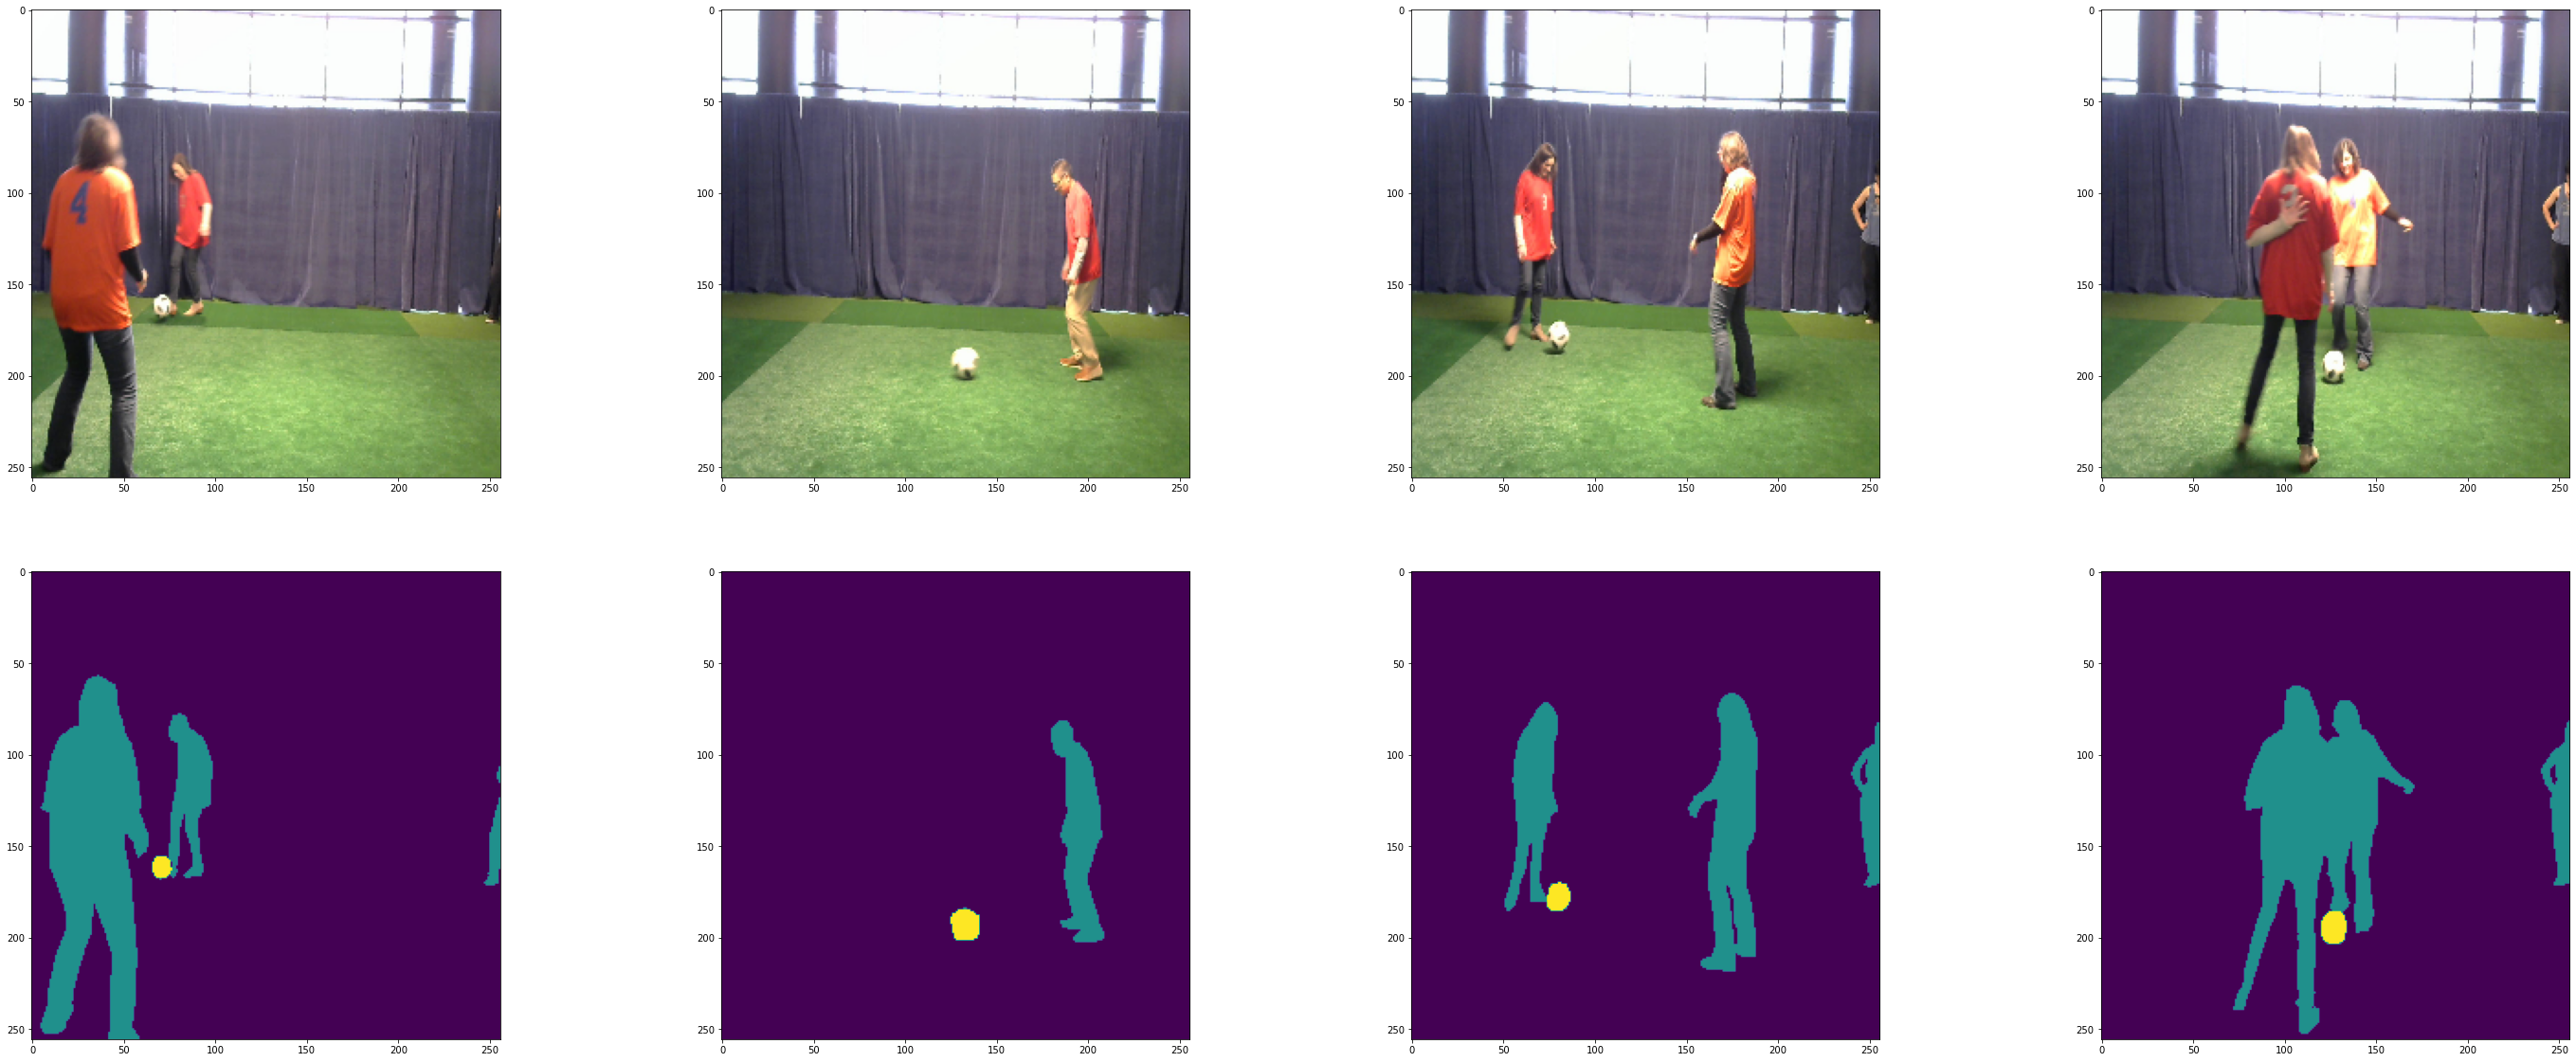

In [15]:
# Display input and ground truth images from 
# an image segmentation training data set.
display_segmentation_images(s, 
                            # Input image table name
                            'segTrainTbl_1', 
                            # Number of images to display
                            n_images=4, 
                            # Ground truth table name
                            segmentation_labels_table='segTrainTbl_1')

The ground truth class maps above use the color navy blue to represent pixels belonging to class 0 (background), the color teal to represent pixels belonging to class 1 (player), and the color yellow to represent pixels belonging to class 2 (ball).

After observing how the image segmentation model training data has been derived and combined thus far, including the validation steps that were taken along the way, one might wonder, "Is there a more efficient way to produce image segmentation model training data, given access to CAS tables consisting of validated raw image and mask ground truth data?" 

Yes, there is...

<a id="createSegmentationTbl"></a>

### Use SAS DLPy to Quickly Generate Image Segmentation Training Data 

So far, the example uploaded and created separate `raw` image and `mask` ground truth data tables in SAS CAS. The imported `raw` and `mask` tables were inspected and validated. Then the columns in the `mask` ground truth table were renamed and reorganized prior to a join. Afterwards, the `raw` image and `mask` ground truth tables were merged using CAS `dljoin()`. The final result is a training data set for a deep learning image segmentation model.

After performing the multiple steps and data manipulations to create the image segmentation training data set from separate `raw` and `mask` data sets, it would be nice to find a simpler, quicker way. 

If you have a validated server-side collection of raw input images and mask ground truth images, you can use the SAS DLPy `create_segmentation_table()` function to quickly and simply create a model training table for use with image segmentation models. The DLPy function ouput should produce the same table as `segTrainTbl_1`, which was just created using traditional methods. 

The DLPy `create_segmentation_table()` function example below uses only a few lines of simple code and the defined server-side path variables `raw_images` and `mask_images` to point to the raw and mask files.

Use `create_segmentation_table()` with the same input tables to create a new image segmentation training data table called `segTrainTbl_2`, and then compare it to the original table `segTrainTbl_1`:

In [16]:
# Create Image Segmentation Training Data Table segTrainTbl_2
segTrainTbl_2 = create_segmentation_table(s,
                                          # specify raw image path using var raw_images
                                          path_to_images=raw_images,
                                          
                                          # specify ground truth path using var mask_images
                                          path_to_ground_truth=mask_images                                         
                                         )

NOTE: Images are loaded
NOTE: Ground truth images are loaded
NOTE: Added action set 'deepLearn'.


The image segmentation training table `segTrainTbl_2` is created. How does it compare with image segmentation training table `segTrainTbl_1`? 

Use the `fetch()` function to compare the table structures and data contents of the two tables. 

In [17]:
segTrainTbl_2.fetch(to=4)

,_filename_0,_image_,_label_,_id_,labels
0,0307_image10.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,0307_image14.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,0307_image12.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,0307_image13.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


Are the table contents the same? Use the `display_segmentation_images()` function to check. Note in the output above that the CAS output name for the table is named `seg_data`.

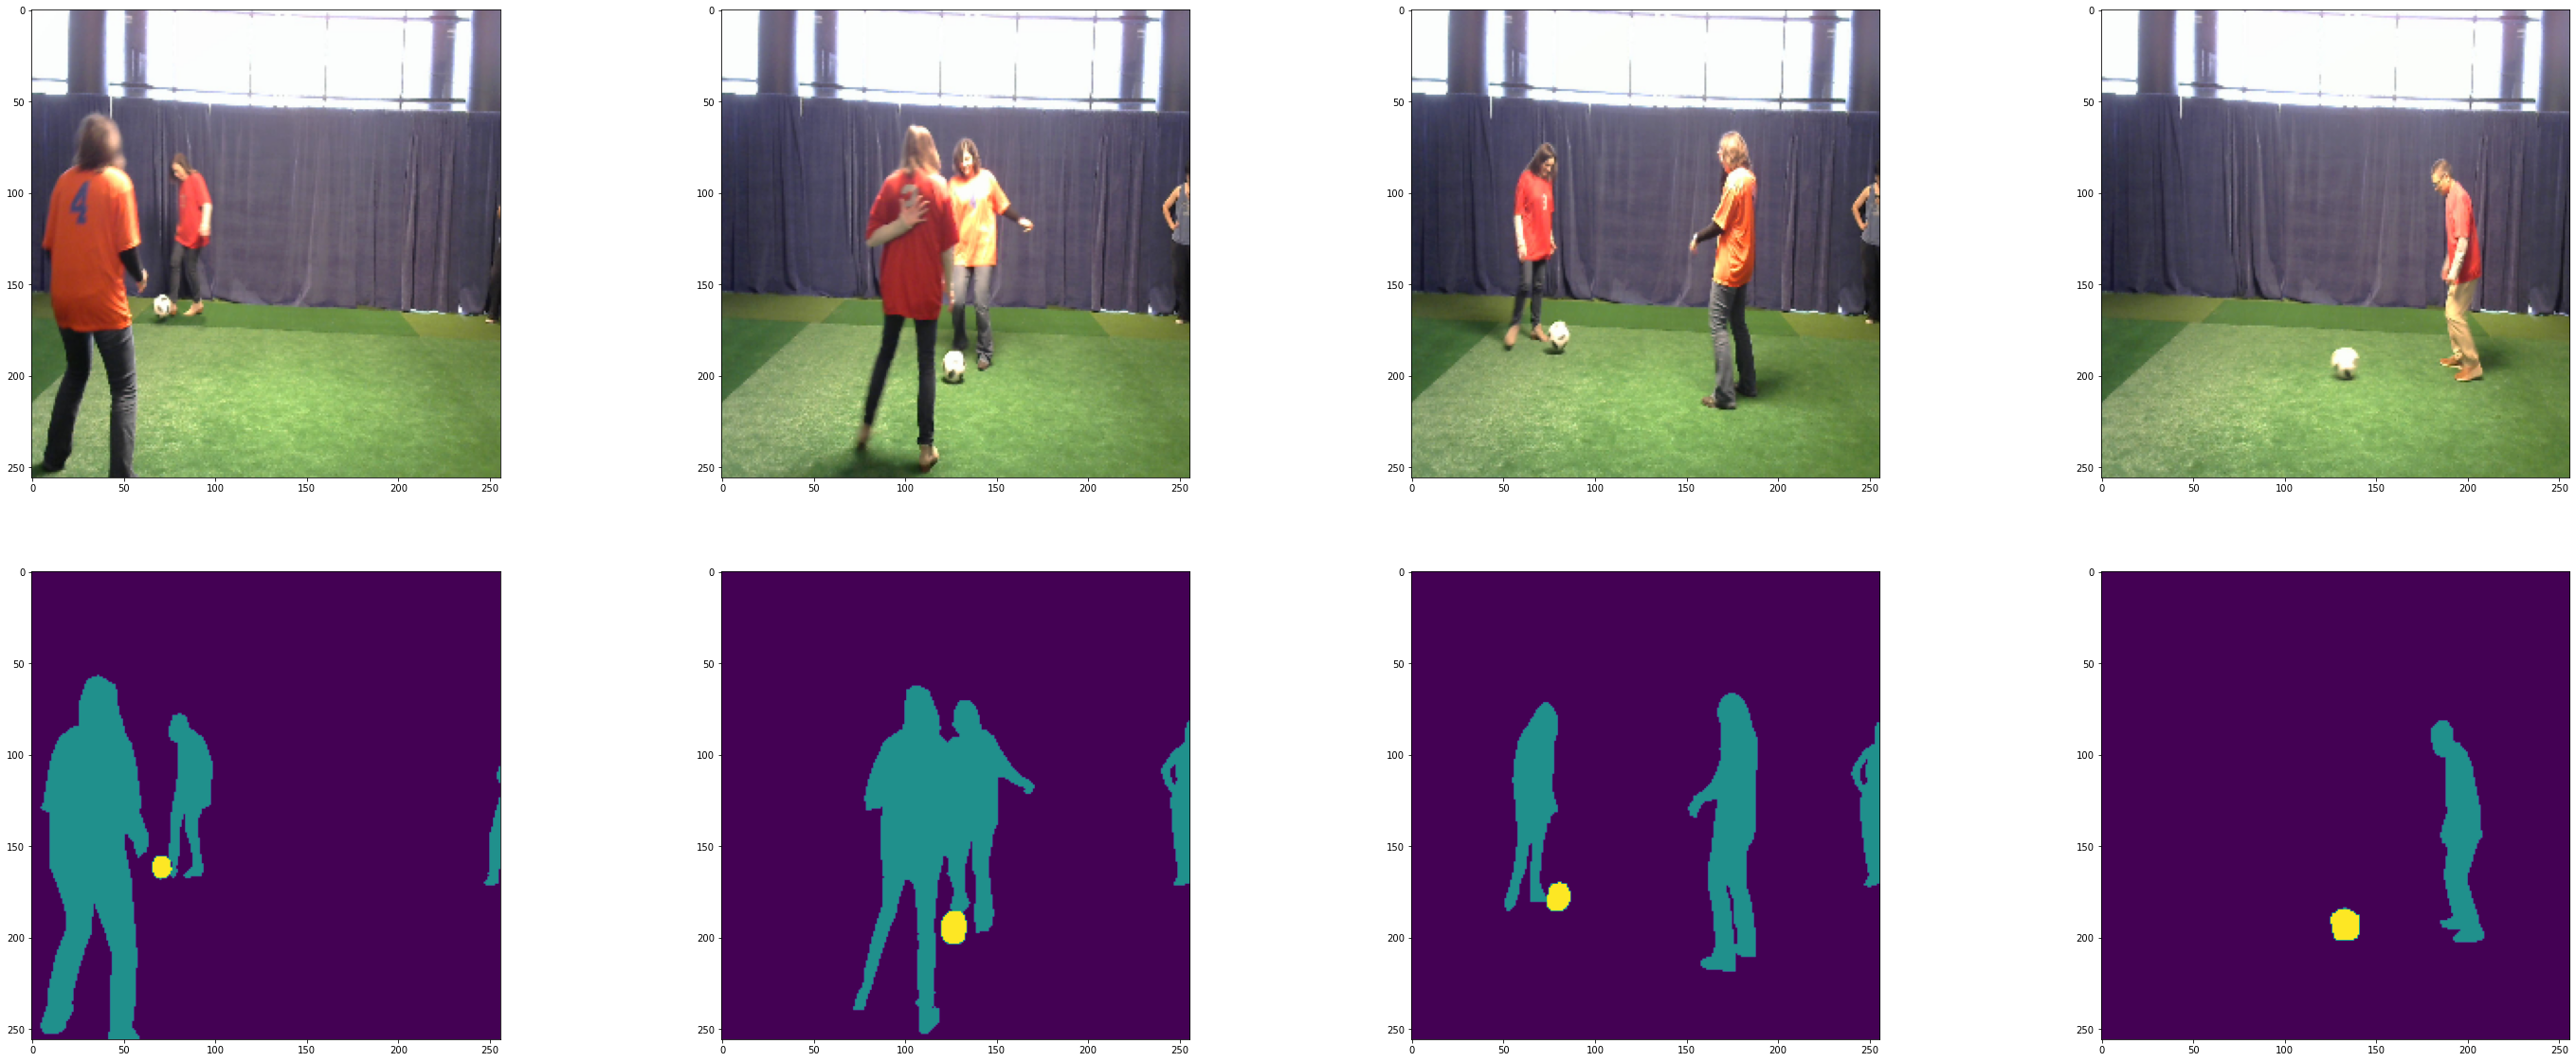

In [18]:
display_segmentation_images(s, 
                            'seg_data', 
                            n_images=4, 
                            segmentation_labels_table='seg_data')

If you compare the fetched row data from both training tables, there is variation in the _order_ of the observations in the two training data sets, but not in the analytic _content_ of the two training tables. The order of observations in image segmentation training data is not significant. (In fact, randomizing training data observations for this task tends to improve training data performance.)

When compared, the analytic image segmentation results from both image segmentation training tables match.  

<a id="summary"></a>

### Summary
Traditionally, to create image segmentation model training data, a _mask_ ground truth table with pixel-wise class data is edited and joined with a corresponding _raw_ input image table with pixel-wise BGR data. The merged training table contains both BGR values and object class information for every pixel in every image in the input data set. 

The steps to perform this task are consolidated in the time- and effort-saving SAS DLPy `create_segmentation_table()` function.
